# Predicción de la tasa de anillamiento de aves
**Autores:** DANIELLE MAREE MCKENNEY & MARIA JOSÉ CASTRO PÉREZ   &nbsp;&nbsp;&nbsp; **Última modificación:** 14/01/2024

In [124]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scipy.spatial import distance_matrix
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1.Lectura del dataset

### 1.1 Definición de funciones auxiliares

In [125]:
def cleanRawData(rawData, relevantColumns):
    # returns a dataframe with only the relevent columns and with invalid location entries removed
    df = rawData.filter(items=relevantColumns)
    df = df[(df['decimalLatitude'] != 0) & (df['decimalLongitude'] != 0)]
    return df

def fillInCounts0(data, dateCombination):
    # Fill in count=0 in the grouped summary
    # Get all unique combinations of the date combination
    existing_combinations = data[dateCombination].drop_duplicates()

    # Create a DataFrame with all unique species
    all_species_combinations = pd.DataFrame({'species': data['species'].unique()})

    # Cross join (cartesian product) to get all combinations of 'species', 'eventDate', and 'locality'
    all_combinations = pd.merge(existing_combinations.assign(key=1), all_species_combinations.assign(key=1), on='key').drop('key', axis=1)

    # Merge with the original DataFrame to get counts
    on = dateCombination.append('species')
    result_df = pd.merge(all_combinations, data, on=on, how='left').fillna(0)
    return result_df

In [126]:
## 1. LECTURA DEL DATASET
DATOS = pd.read_csv('./DATASET.csv', sep="\t", on_bad_lines="warn")
relevantColumns = ['species','locality','decimalLatitude', 'decimalLongitude', 'eventDate', 'stateProvince']

df = cleanRawData(DATOS, relevantColumns)

### 1.2 Agrupaciones por semana, mes, quarter y año

In [127]:

# Group by 'species', 'eventDate', and 'stateProvince' and count the rows in each group
grouped_eventDate_df = df.groupby(['species', 'eventDate', 'stateProvince']).size().reset_index(name='count')
# Fill in count=0 on days where a locality was visited but no entry was made for that species
grouped_eventDate_df = fillInCounts0(grouped_eventDate_df, ['eventDate', 'stateProvince'])
#print(grouped_eventDate_df[10:])


# Supongamos que 'grouped_eventDate_df' es tu DataFrame y 'eventDate' es la columna que contiene fechas
grouped_eventDate_df['eventDate'] = pd.to_datetime(grouped_eventDate_df['eventDate'])

grouped_eventDate_df['weekOfYear'] = grouped_eventDate_df['eventDate'].dt.isocalendar().week 
grouped_eventDate_df['month'] = grouped_eventDate_df['eventDate'].dt.month
grouped_eventDate_df['quarter'] = grouped_eventDate_df['eventDate'].dt.to_period('Q')
grouped_eventDate_df['year'] = grouped_eventDate_df['eventDate'].dt.year

grouped_weekOfYear_df = grouped_eventDate_df.groupby(['species', 'weekOfYear', 'year', 'stateProvince']).sum('count').reset_index()

grouped_month_df = grouped_eventDate_df.groupby(['species', 'month', 'year', 'stateProvince']).sum('count').reset_index()

grouped_quarter_df = grouped_eventDate_df.groupby(['species', 'quarter', 'stateProvince']).sum('count').reset_index()

grouped_year_df = grouped_eventDate_df.groupby(['species', 'year', 'stateProvince']).sum('count').reset_index()



### 2.1. Conteo de especies por año

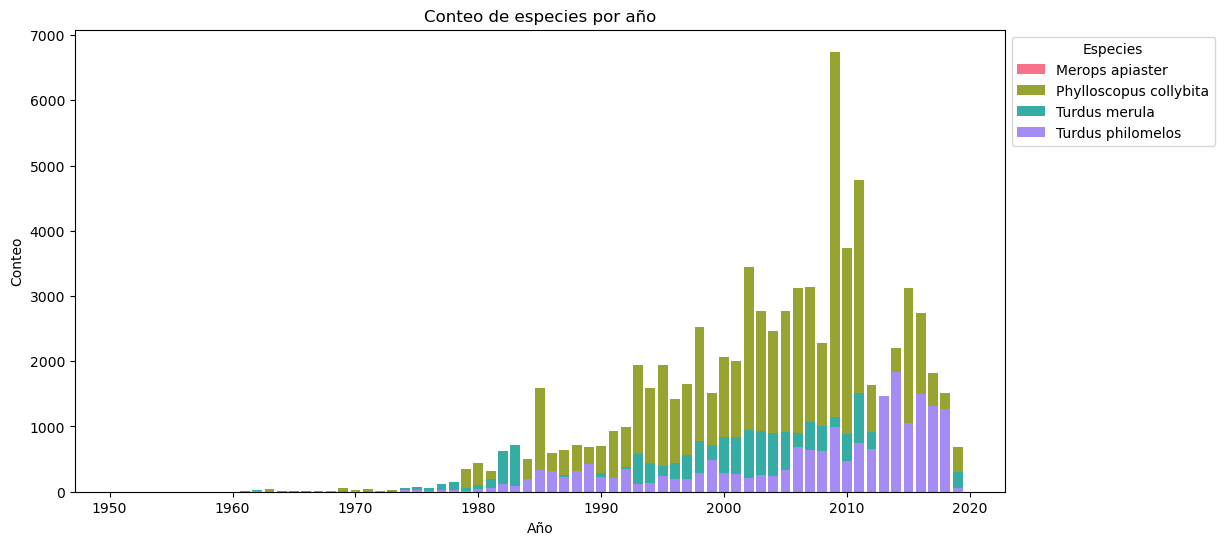

In [128]:
### 2.1. Conteo de especies por año
import matplotlib.pyplot as plt
import seaborn as sns

# Crear una paleta de colores única basada en todas las especies
paleta_colores = sns.color_palette('husl', n_colors=len(grouped_year_df['species'].unique()))
# Mapear cada especie a un color específico
especies_a_colores = dict(zip(grouped_year_df['species'].unique(), paleta_colores))

# Conteo de especies por año
plt.figure(figsize=(12, 6))
for species, data in grouped_year_df.groupby('species'):
    plt.bar(data['year'], data['count'], label=species, color=especies_a_colores[species])
plt.xlabel('Año')
plt.ylabel('Conteo')
plt.title('Conteo de especies por año')
plt.legend(title='Especies', bbox_to_anchor=(1, 1))
plt.show()

### 2.2. Conteo de especies por provincia en los años 2018 al 2019

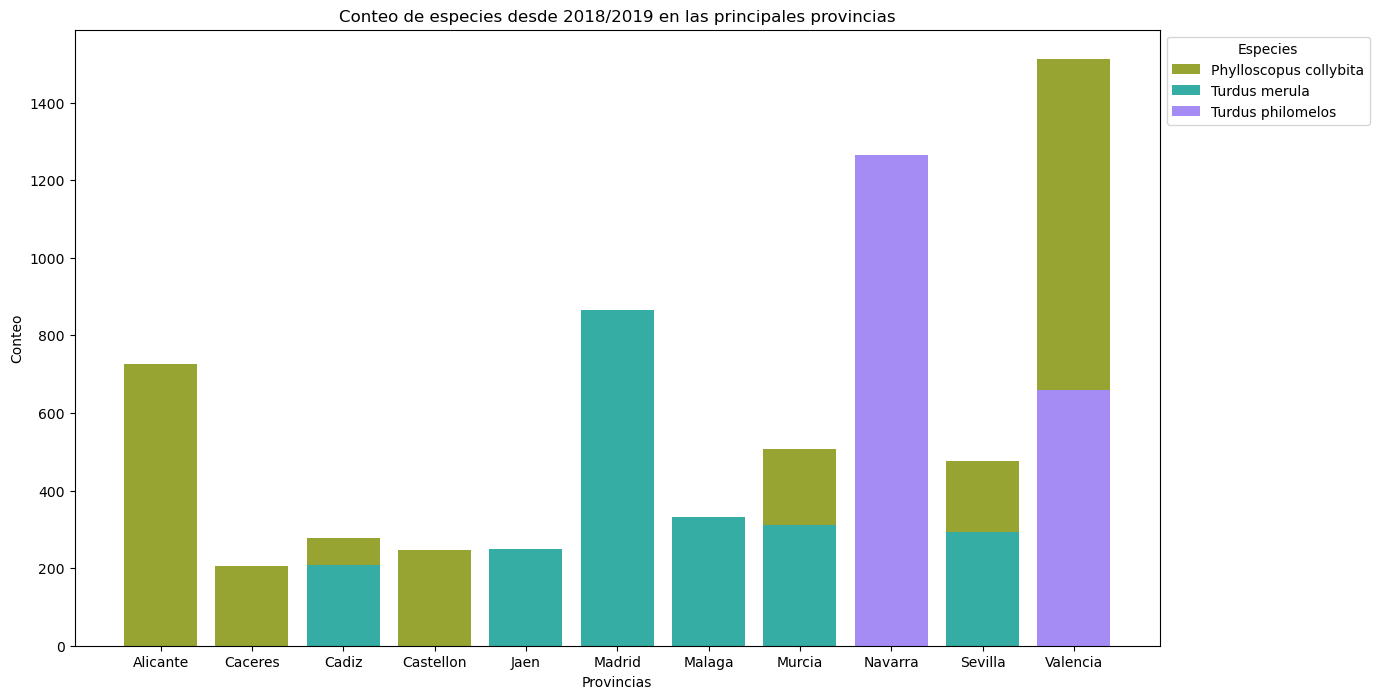

In [144]:
### 2.2. Conteo de especies por provincia en los años 2018 al 2019
plt.figure(figsize=(14, 8))
rango_anos = range(2018, 2019)
df_filtrado = grouped_year_df[(grouped_year_df['year'].isin(rango_anos)) & (grouped_year_df['count'] > 200)]

for species, data in df_filtrado.groupby('species'):
    plt.bar(data['stateProvince'], data['count'], label=species, color=especies_a_colores[species])
plt.xlabel('Provincias')
plt.ylabel('Conteo')
plt.title('Conteo de especies desde 2018/2019 en las principales provincias')
plt.legend(title='Especies', bbox_to_anchor=(1, 1))
plt.show()

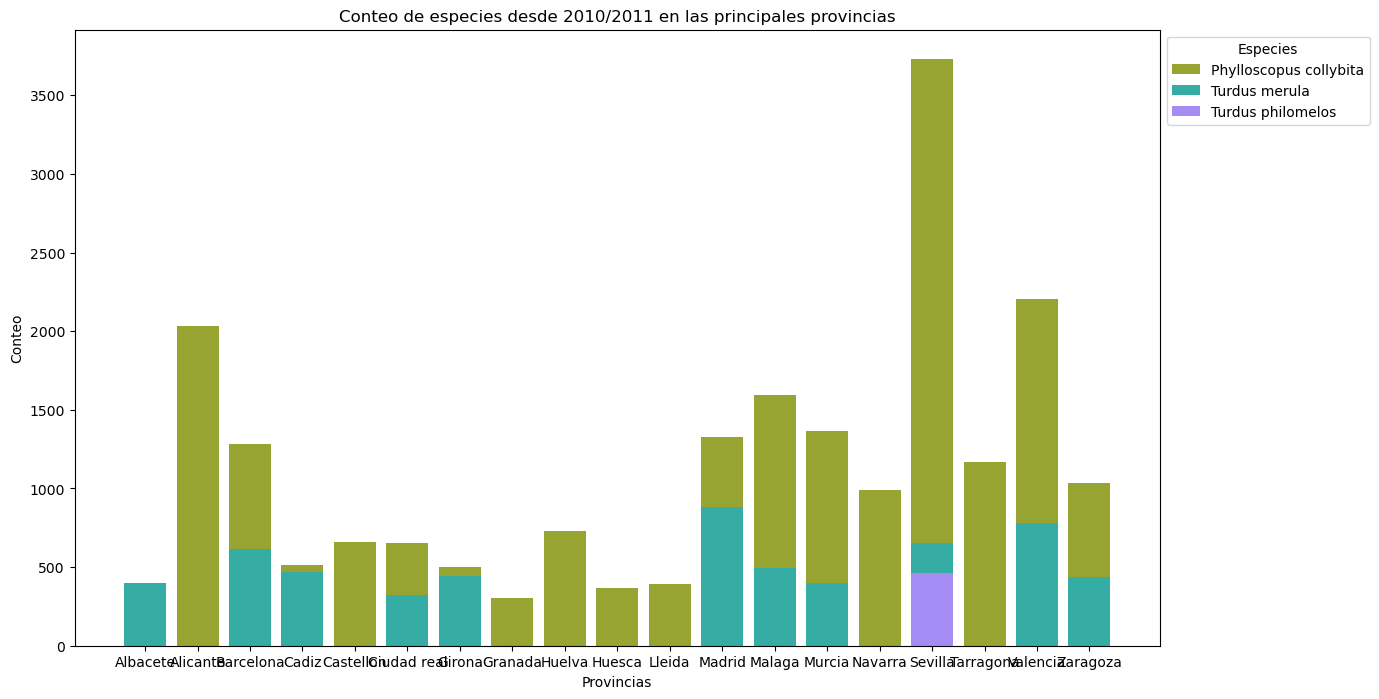

In [147]:
plt.figure(figsize=(14, 8))
rango_anos = range(2010, 2011)
df_filtrado = grouped_year_df[(grouped_year_df['year'].isin(rango_anos)) & (grouped_year_df['count'] > 300)]

for species, data in df_filtrado.groupby('species'):
    plt.bar(data['stateProvince'], data['count'], label=species, color=especies_a_colores[species])
plt.xlabel('Provincias')
plt.ylabel('Conteo')
plt.title('Conteo de especies desde 2010/2011 en las principales provincias')
plt.legend(title='Especies', bbox_to_anchor=(1, 1))
plt.show()

### 2.3. Estacionalidad - Conteo de especies por meses

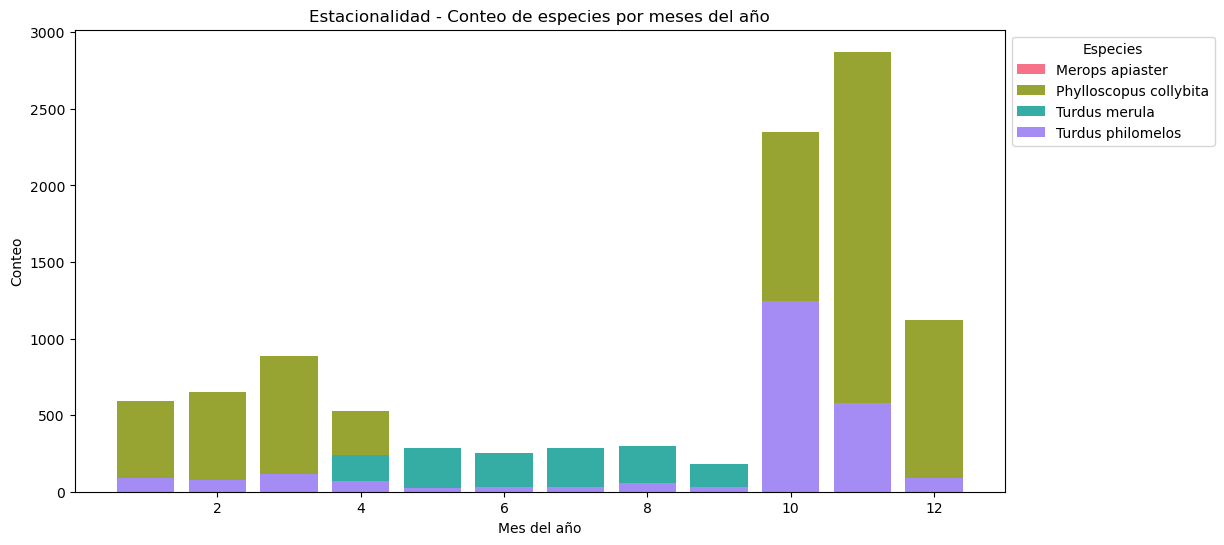

In [153]:
### 2.3. Estacionalidad - Conteo de especies por meses
plt.figure(figsize=(12, 6))
for species, data in grouped_month_df.groupby('species'):
    plt.bar(data['month'], data['count'], label=species, color=especies_a_colores[species])
plt.xlabel('Mes del año')
plt.ylabel('Conteo')
plt.title('Estacionalidad - Conteo de especies por meses del año')
plt.legend(title='Especies', bbox_to_anchor=(1, 1))
plt.show()



## 3.Turdus merula : Mirlo

### 3.1. Conteo de Mirlo por año

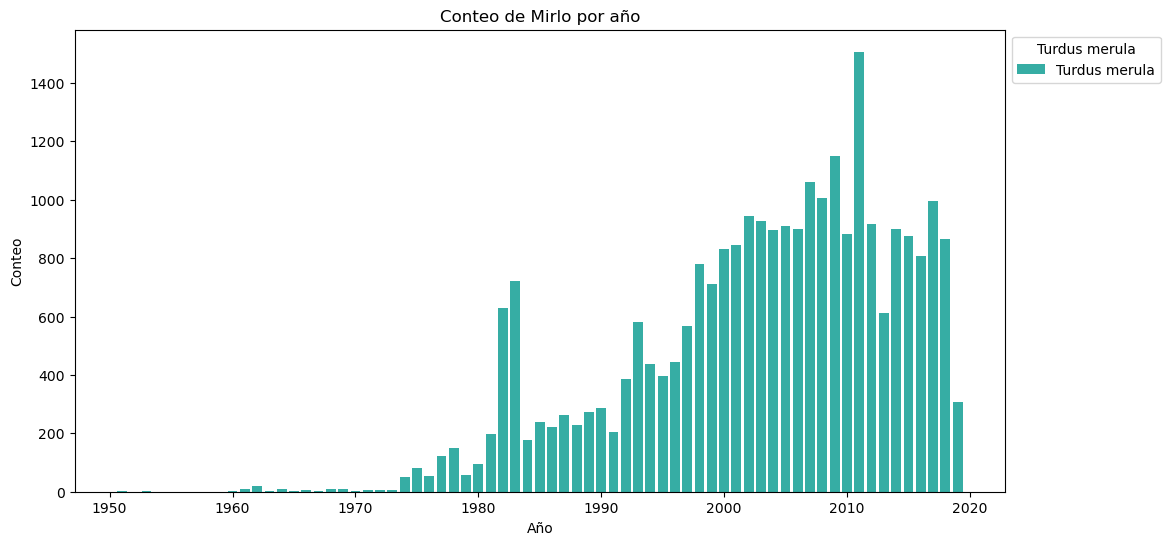

In [131]:
## 3.Turdus merula ("Mirlo")
## Estudio de observaciones sobre Turdus merula ("Mirlo")
especie = 'Turdus merula'
nombre_comun = 'Mirlo'
df_filtrado = grouped_year_df[grouped_year_df['species'] == especie]
    
### 3.1. Conteo de Mirlo por año
plt.figure(figsize=(12, 6))
plt.bar(df_filtrado['year'], df_filtrado['count'], color=especies_a_colores[especie], label=especie)
plt.xlabel('Año')
plt.ylabel('Conteo')
plt.title('Conteo de ' +nombre_comun +' por año')
plt.legend(title=especie, bbox_to_anchor=(1, 1))
# Mostrar el gráfico
plt.show()


### 3.2.Conteo de Mirlo por provincia

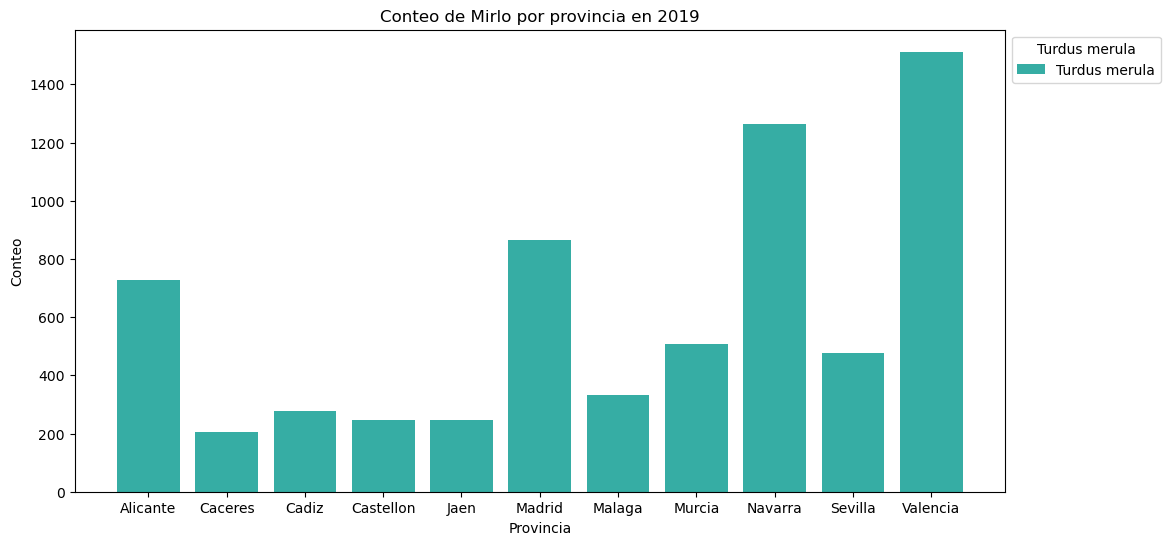

In [132]:
### 3.2. Conteo de Mirlo por provincia
rango_anos = (2018,2019)
df_filtrado = grouped_year_df[(grouped_year_df['year'].isin(rango_anos)) & (grouped_year_df['count'] > 200)]

plt.figure(figsize=(12, 6))
plt.bar(df_filtrado['stateProvince'], df_filtrado['count'], color=especies_a_colores[especie], label=especie)
plt.xlabel('Provincia')
plt.ylabel('Conteo')
plt.title('Conteo de ' +nombre_comun +' por provincia en 2019')
plt.legend(title=especie, bbox_to_anchor=(1, 1))
# Mostrar el gráfico
plt.show()

## 4.Merops apiaster: Abejaruco

### 4.1. Conteo de Abejaruco por año

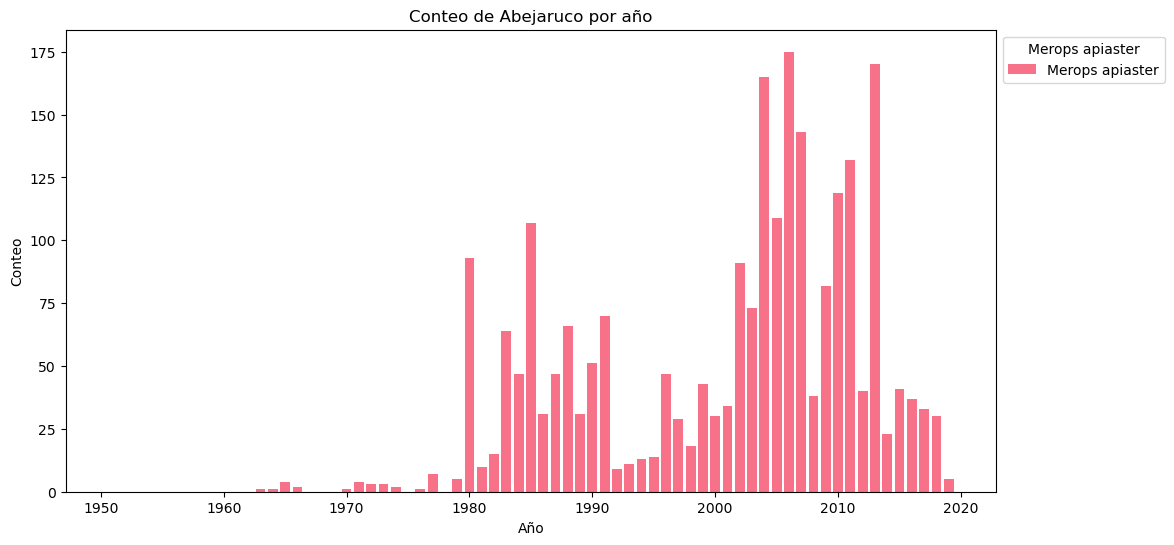

In [133]:
#Estudio de Merops apiaste ("Abejaruco ")
especie = 'Merops apiaster'
nombre_comun = 'Abejaruco'
df_filtrado = grouped_year_df[grouped_year_df['species'] == especie]
    
### 3.1. Conteo de Mirlo por año
plt.figure(figsize=(12, 6))
plt.bar(df_filtrado['year'], df_filtrado['count'], color=especies_a_colores[especie], label=especie)
plt.xlabel('Año')
plt.ylabel('Conteo')
plt.title('Conteo de ' +nombre_comun +' por año')
plt.legend(title=especie, bbox_to_anchor=(1, 1))
# Mostrar el gráfico
plt.show()


### 4.2. Conteo de Abejaruco por provincia

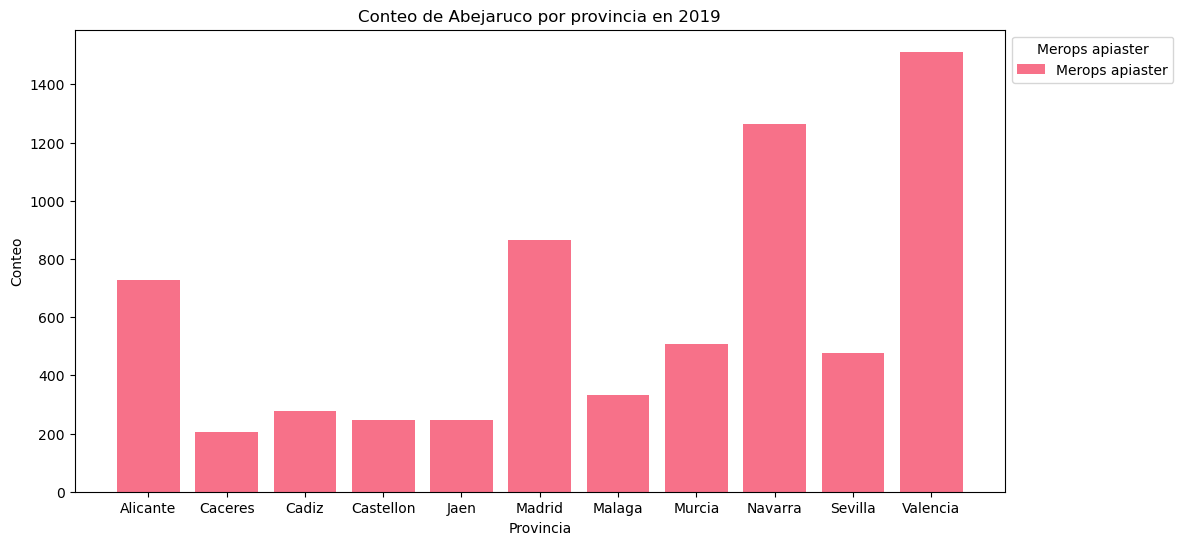

In [134]:
### 3.2. Conteo de Mirlo por provincia
rango_anos = (2018,2019)
df_filtrado = grouped_year_df[(grouped_year_df['year'].isin(rango_anos)) & (grouped_year_df['count'] > 200)]

plt.figure(figsize=(12, 6))
plt.bar(df_filtrado['stateProvince'], df_filtrado['count'], color=especies_a_colores[especie], label=especie)
plt.xlabel('Provincia')
plt.ylabel('Conteo')
plt.title('Conteo de ' +nombre_comun +' por provincia en 2019')
plt.legend(title=especie, bbox_to_anchor=(1, 1))
# Mostrar el gráfico
plt.show()

## 5.Phylloscopus collybita: Mosquitero común
### 5.1. Conteo de Mosquitero común por año
### 5.2. Conteo de Mosquitero común por provincia

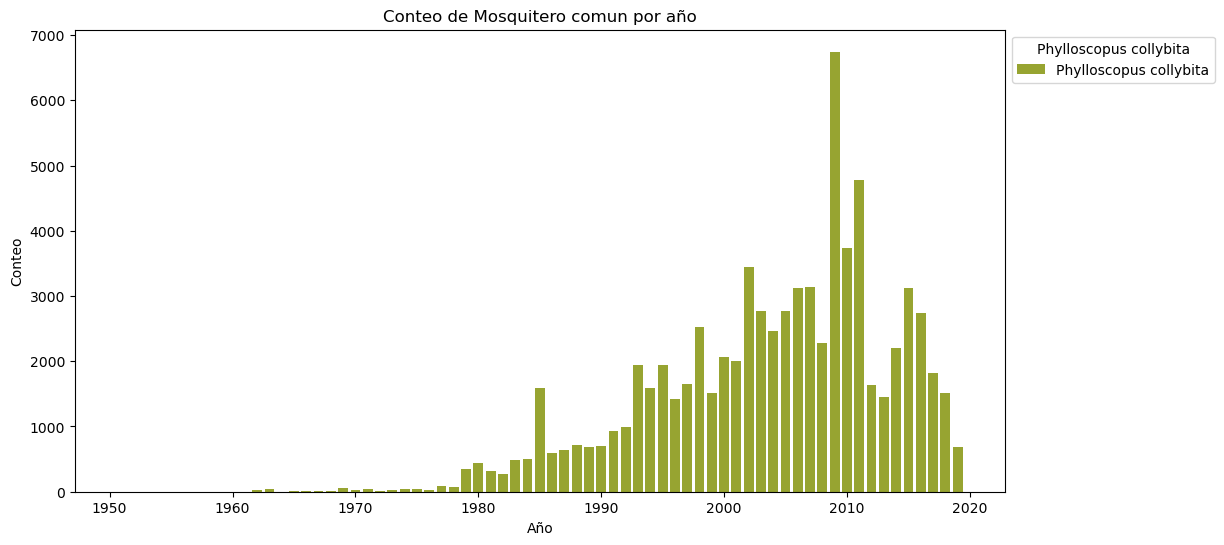

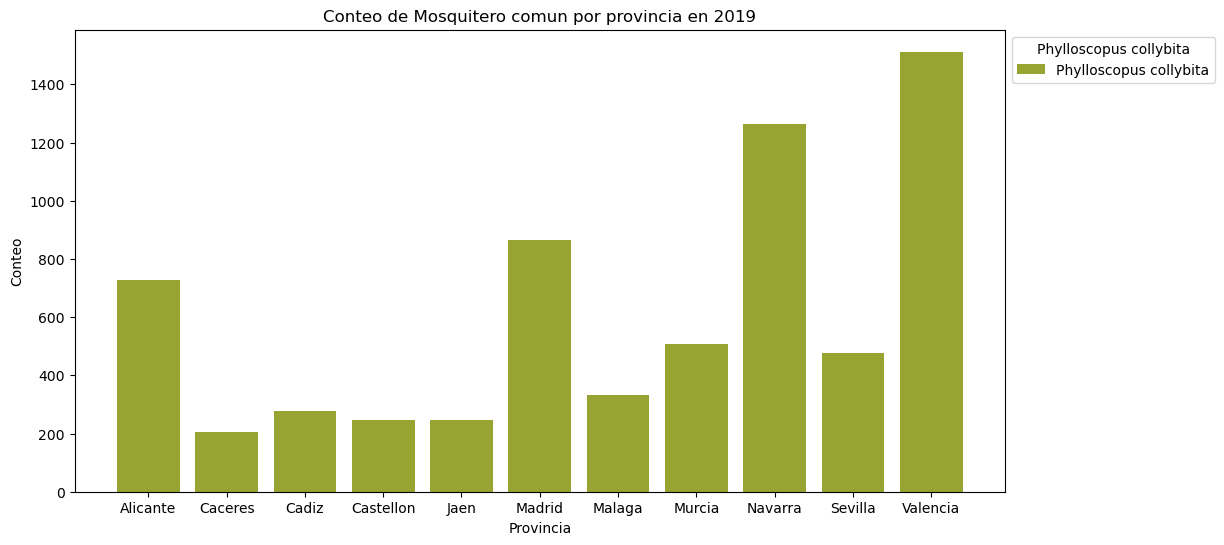

In [135]:
#Estudio de Phylloscopus collybita ("Mosquitero común")
especie = 'Phylloscopus collybita'
nombre_comun = 'Mosquitero comun'
df_filtrado = grouped_year_df[grouped_year_df['species'] == especie]
    
### 3.1. Conteo de Mirlo por año
plt.figure(figsize=(12, 6))
plt.bar(df_filtrado['year'], df_filtrado['count'], color=especies_a_colores[especie], label=especie)
plt.xlabel('Año')
plt.ylabel('Conteo')
plt.title('Conteo de ' +nombre_comun +' por año')
plt.legend(title=especie, bbox_to_anchor=(1, 1))
# Mostrar el gráfico
plt.show()

df_filtrado = grouped_year_df[(grouped_year_df['year'].isin(rango_anos)) & (grouped_year_df['count'] > 200)]

plt.figure(figsize=(12, 6))
plt.bar(df_filtrado['stateProvince'], df_filtrado['count'], color=especies_a_colores[especie], label=especie)
plt.xlabel('Provincia')
plt.ylabel('Conteo')
plt.title('Conteo de ' +nombre_comun +' por provincia en 2019')
plt.legend(title=especie, bbox_to_anchor=(1, 1))
# Mostrar el gráfico
plt.show()

## 6.Turdus philomelos: Zorzal común
### 6.1. Conteo de Zorzal común por año
### 6.2. Conteo de Zorzal común por provincia

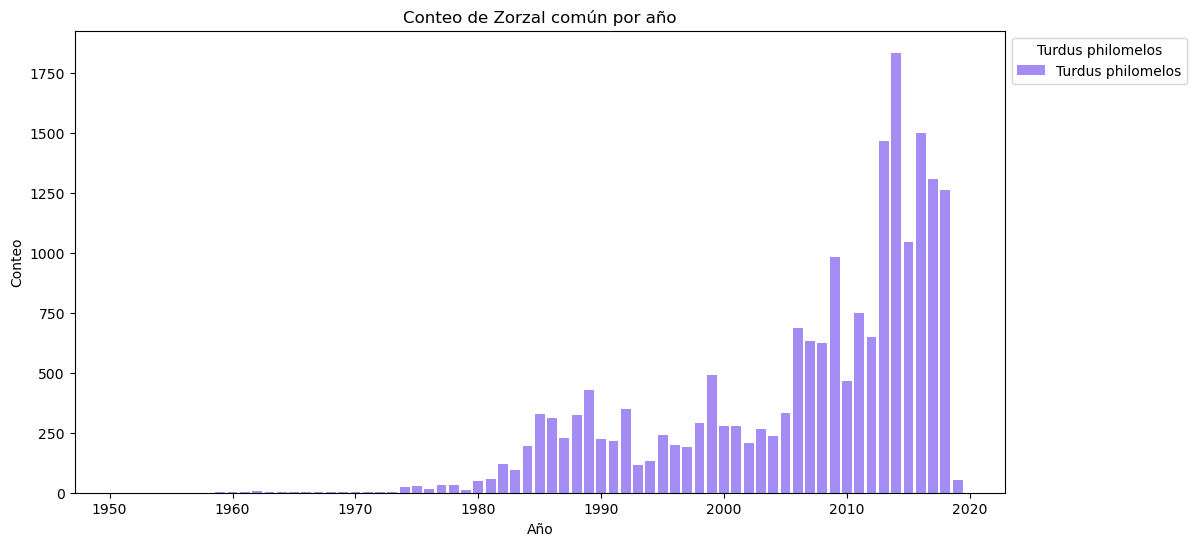

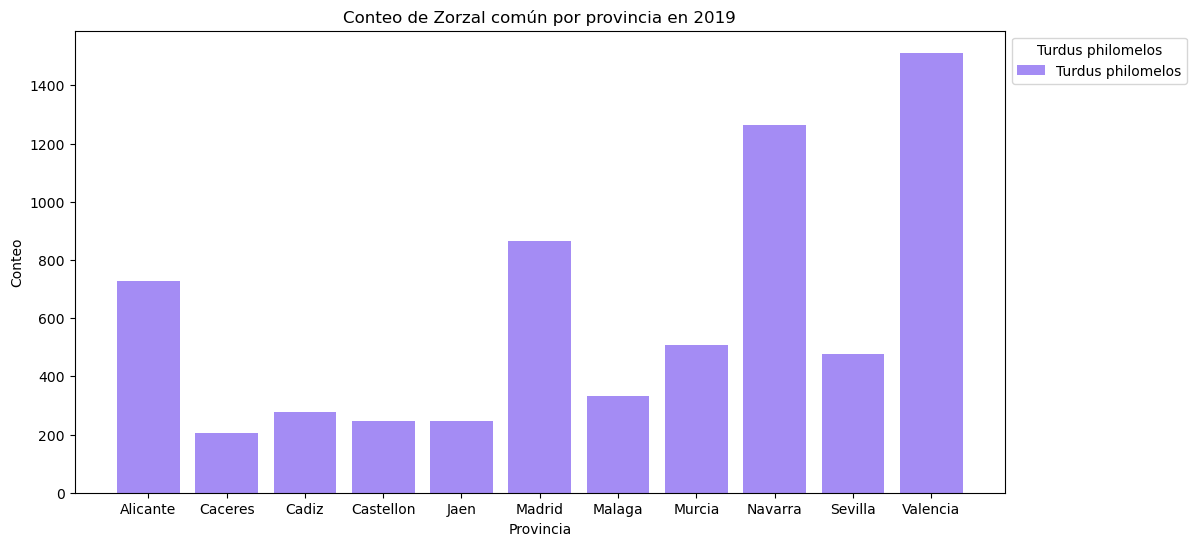

In [136]:

#Estudio de Turdus philomelos ("Zorzal común") 
especie = 'Turdus philomelos'
nombre_comun = 'Zorzal común'

df_filtrado = grouped_year_df[grouped_year_df['species'] == especie]
    
### 3.1. Conteo de Mirlo por año
plt.figure(figsize=(12, 6))
plt.bar(df_filtrado['year'], df_filtrado['count'], color=especies_a_colores[especie], label=especie)
plt.xlabel('Año')
plt.ylabel('Conteo')
plt.title('Conteo de ' +nombre_comun +' por año')
plt.legend(title=especie, bbox_to_anchor=(1, 1))
# Mostrar el gráfico
plt.show()

df_filtrado = grouped_year_df[(grouped_year_df['year'].isin(rango_anos)) & (grouped_year_df['count'] > 200)]

plt.figure(figsize=(12, 6))
plt.bar(df_filtrado['stateProvince'], df_filtrado['count'], color=especies_a_colores[especie], label=especie)
plt.xlabel('Provincia')
plt.ylabel('Conteo')
plt.title('Conteo de ' +nombre_comun +' por provincia en 2019')
plt.legend(title=especie, bbox_to_anchor=(1, 1))
# Mostrar el gráfico
plt.show()